# Text classification with LSTMs


In [39]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import LSTM, Embedding, TextVectorization
from keras.models import Model
from keras.optimizers.legacy import Adam  # For macos compatibility

In [1]:
!wget -nc https://lazyprogrammer.me/course_files/spam.csv

--2025-03-22 17:54:12--  https://lazyprogrammer.me/course_files/spam.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 2606:4700:3031::6815:17d2, 2606:4700:3030::ac43:d5a6, 172.67.213.166, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|2606:4700:3031::6815:17d2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 503663 (492K) [text/csv]
Saving to: ‘spam.csv’

spam.csv            100%[===================>] 491,86K  1,09MB/s    in 0,4s    

2025-03-22 17:54:14 (1,09 MB/s) - ‘spam.csv’ saved [503663/503663]



In [2]:
!head ../datasets/spam.csv

v1,v2,,,
ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",,,
ham,Ok lar... Joking wif u oni...,,,
spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,,,
ham,U dun say so early hor... U c already then say...,,,
ham,"Nah I don't think he goes to usf, he lives around here though",,,
spam,"FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, �1.50 to rcv",,,
ham,Even my brother is not like to speak with me. They treat me like aids patent.,,,
ham,As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune,,,
spam,WINNER!! As a valued network customer you have been selected to receivea �900 prize reward! To claim call 09061701461. Claim 

In [19]:
df = pd.read_csv('../datasets/spam.csv', encoding='ISO-8859-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [20]:
# Cleaning data
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], inplace=True, axis=1)
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [21]:
# Renaming columns
df.columns = ['labels', 'data']
df.head()

,labels,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
# Creating binary labels
df['binary_labels'] = df['labels'].map({'ham': 0, 'spam': 1})

In [24]:
# Getting target values
Y = df['binary_labels'].values

In [25]:
# Splitting the data
df_train, df_test, Y_train, Y_test = train_test_split(
    df['data'],
    Y,
    test_size=1 / 3,
)

## Processing strings while training


In [27]:
# Create tf datasets
train_ds = tf.data.Dataset.from_tensor_slices((df_train.values, Y_train))
test_ds = tf.data.Dataset.from_tensor_slices((df_test.values, Y_test))

In [28]:
# Convert sentences to sequences
MAX_VOCAB_SIZE = 20000
vectorization = TextVectorization(max_tokens=MAX_VOCAB_SIZE)
vectorization.adapt(train_ds.map(lambda x, y: x))

In [29]:
# Shuffle and batch the dataset
train_ds = train_ds.shuffle(buffer_size=10000).batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Getting size of vocabulary
V = len(vectorization.get_vocabulary())

# Choosing embedding dimensionality
D = 20

# Hidden state dimensionality
M = 15

In [ ]:
# Creating model
i = Input(
    shape=(1,),  # Shape is 1 because the vectorization hasn't happened yet
    dtype=tf.string,  # We specify the dtype here else we get a cast error (string -> float)
)
x = vectorization(i)
x = Embedding(V, D)(x)
x = LSTM(M, return_sequences=True)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(i, x)

In [110]:
model.summary()

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, None)              0         
 ctorization)                                                    
                                                                 
 embedding_16 (Embedding)    (None, None, 20)          154240    
                                                                 
 lstm_16 (LSTM)              (None, None, 15)          2160      
                                                                 
 global_max_pooling1d_15 (G  (None, 15)                0         
 lobalMaxPooling1D)                                              
                                                                 
 dense_15 (Dense)            (None, 1)                 16 

In [35]:
# Compiling and fitting the model
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(),
    metrics=['accuracy'],
)

r = model.fit(
    train_ds,
    epochs=10,
    validation_data=test_ds,
)

Epoch 1/10
117/117 [==============================] - 2s 6ms/step - loss: 0.4597 - accuracy: 0.8516 - val_loss: 0.3162 - val_accuracy: 0.8644
Epoch 2/10
117/117 [==============================] - 1s 5ms/step - loss: 0.1746 - accuracy: 0.9572 - val_loss: 0.1322 - val_accuracy: 0.9736
Epoch 3/10
117/117 [==============================] - 1s 5ms/step - loss: 0.0761 - accuracy: 0.9884 - val_loss: 0.1011 - val_accuracy: 0.9774
Epoch 4/10
117/117 [==============================] - 1s 5ms/step - loss: 0.0537 - accuracy: 0.9908 - val_loss: 0.0715 - val_accuracy: 0.9839
Epoch 5/10
117/117 [==============================] - 1s 5ms/step - loss: 0.0364 - accuracy: 0.9943 - val_loss: 0.0881 - val_accuracy: 0.9790
Epoch 6/10
117/117 [==============================] - 1s 5ms/step - loss: 0.0267 - accuracy: 0.9965 - val_loss: 0.0880 - val_accuracy: 0.9812
Epoch 7/10
117/117 [==============================] - 1s 5ms/step - loss: 0.0205 - accuracy: 0.9976 - val_loss: 0.0926 - val_accuracy: 0.9801
Epoch 

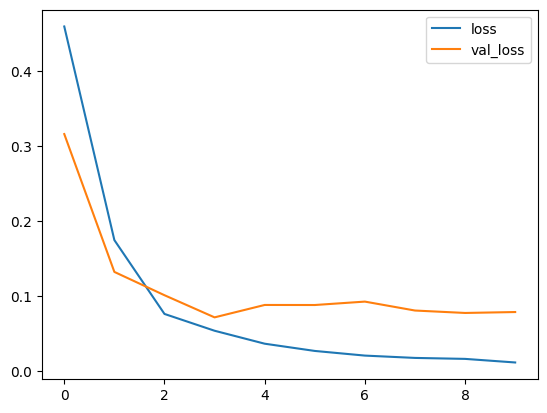

In [37]:
# Plotting loss per iteration
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

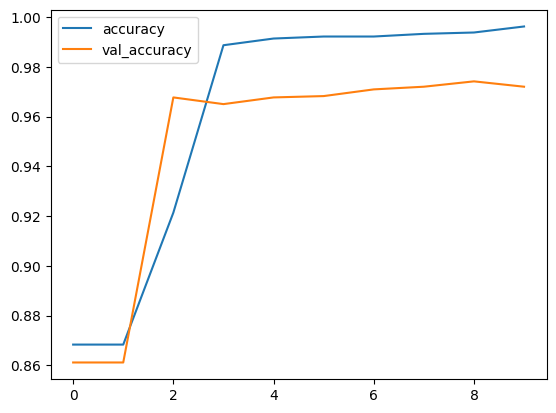

In [111]:
# Plotting accuracy per iteration
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

<Axes: >

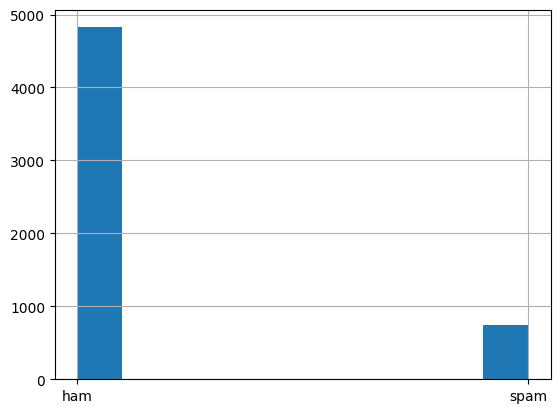

: 

In [ ]:
# Checking how balanced the data is
df['labels'].hist()

In [40]:
# Getting f1 score because of unbalanced datasets
f1_score(
    Y_train,
    model.predict(df_train.values) > 0.5,  # if greater than 0.5 return 1, else 0
)

117/117 [==============================] - 0s 1ms/step


0.9979550102249489

In [41]:
# Getting f1 score because of unbalanced datasets
f1_score(
    Y_test,
    model.predict(df_test.values) > 0.5,
)

59/59 [==============================] - 0s 1ms/step


0.932806324110672

## Processing strings before training

When doing the modelling with the processing of strings in the training, the model transforms the strings every epoch, which is highly inefficient. Also important to note that strings take up much more space than integers.


In [96]:
# What if we pre-convert strings to ints?
train_ints = vectorization(df_train.values)
test_ints = vectorization(df_test.values)

In [97]:
train_ints.shape

TensorShape([3714, 171])

In [98]:
test_ints.shape

TensorShape([1858, 97])

In [99]:
# Creating tf datasets
train_ds = tf.data.Dataset.from_tensor_slices((train_ints, Y_train))
test_ds = tf.data.Dataset.from_tensor_slices((test_ints, Y_test))

In [100]:
# Shuffle and batch the dataset
train_ds = train_ds.shuffle(buffer_size=10000).batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(32).prefetch(tf.data.AUTOTUNE)

In [106]:
# Creating the model
i = Input(shape=(None,))
x = Embedding(V, D)(i)
x = LSTM(M, return_sequences=True)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(i, x)

In [107]:
model.summary()

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, None)]            0         
                                                                 
 embedding_15 (Embedding)    (None, None, 20)          154240    
                                                                 
 lstm_15 (LSTM)              (None, None, 15)          2160      
                                                                 
 global_max_pooling1d_14 (G  (None, 15)                0         
 lobalMaxPooling1D)                                              
                                                                 
 dense_14 (Dense)            (None, 1)                 16        
                                                                 
Total params: 156416 (611.00 KB)
Trainable params: 156416 (611.00 KB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [102]:
# Compiling and fitting model
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(),
    metrics=['accuracy'],
)

r = model.fit(
    train_ds,
    epochs=10,
    validation_data=test_ds,
)

Epoch 1/10
117/117 [==============================] - 2s 16ms/step - loss: 0.4405 - accuracy: 0.8683 - val_loss: 0.3989 - val_accuracy: 0.8611
Epoch 2/10
117/117 [==============================] - 2s 16ms/step - loss: 0.3594 - accuracy: 0.8683 - val_loss: 0.3117 - val_accuracy: 0.8611
Epoch 3/10
117/117 [==============================] - 2s 15ms/step - loss: 0.1739 - accuracy: 0.9214 - val_loss: 0.1600 - val_accuracy: 0.9677
Epoch 4/10
117/117 [==============================] - 2s 15ms/step - loss: 0.1047 - accuracy: 0.9887 - val_loss: 0.1526 - val_accuracy: 0.9650
Epoch 5/10
117/117 [==============================] - 2s 15ms/step - loss: 0.0782 - accuracy: 0.9914 - val_loss: 0.1460 - val_accuracy: 0.9677
Epoch 6/10
117/117 [==============================] - 2s 16ms/step - loss: 0.0667 - accuracy: 0.9922 - val_loss: 0.1458 - val_accuracy: 0.9682
Epoch 7/10
117/117 [==============================] - 2s 15ms/step - loss: 0.0584 - accuracy: 0.9922 - val_loss: 0.1438 - val_accuracy: 0.9709

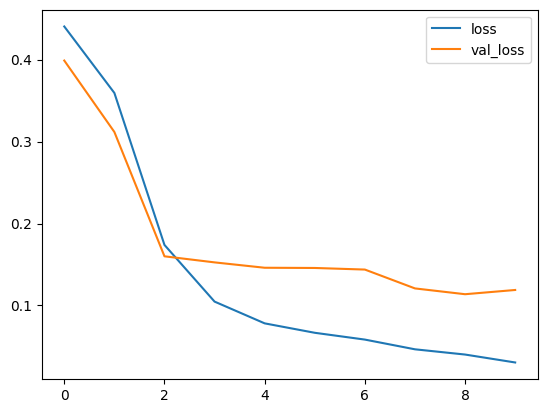

In [103]:
# Plotting loss per iteration
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

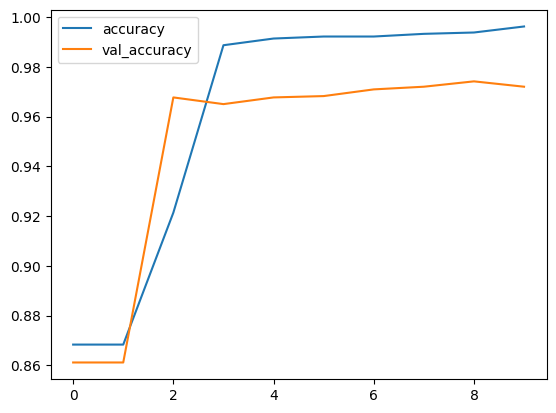

In [104]:
# Plotting accuracy per iteration
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

We end up seeing that the other method had faster training, even though it processed the data every epoch. This may be due to the smaller size of the arrays, given that the padding was done based on the largest sentence in a batch of $32$, instead of the largest sentence in the entire dataset.
